# Context Pruning

## Background from Drew's Post

Context pruning involves removing irrelevant or unnecessary information to dramatically reduce context size while maintaining response quality. Drew Breunig highlights the **Provence tool** as a prime example:

- **Can reduce document size by 95%** while maintaining quality
- **Small footprint** (only 1.75 GB)
- **Easy to implement** with just a few lines of code
- **Dramatic efficiency gains** without sacrificing performance

Key insights from Drew's research:
- Essential for managing large context windows effectively
- Allows models to focus on relevant information
- Can be implemented programmatically for automated context management

## Context Pruning in Practice

**Heuristic Compression and Message Trimming** - https://langchain-ai.github.io/langgraph/how-tos/memory/add-memory/#trim-messages

LangGraph provides several message management strategies to handle context window limitations. The `trim_messages()` function allows you to limit token count by keeping the "last" messages and controlling maximum tokens and message boundaries. This can be implemented as pre-model hooks for agents with custom state management. Key benefits include preventing context window overflow, maintaining conversation context, optimizing memory usage, and enabling long-running conversations. The approach emphasizes flexible, programmatic management of conversational memory across different AI interaction scenarios.

### LangChain's trim_messages Function

The [`trim_messages`](https://python.langchain.com/api_reference/core/messages/langchain_core.messages.utils.trim_messages.html) function is a powerful tool for context pruning that allows you to:

- **Limit token count** by keeping the most recent messages
- **Control message boundaries** to ensure conversations remain coherent
- **Implement custom trimming strategies** based on your specific needs
- **Maintain context quality** while reducing size

**Important considerations:**
- `max_tokens` must be reasonable for your message sizes (128 tokens is often too restrictive)
- `start_on="human"` ensures conversations start with human messages
- `include_system=False` prevents system messages from being counted in token limits
- `strategy="last"` keeps the most recent messages within the token limit

This function is particularly useful for long-running conversations where you need to balance context preservation with performance optimization.

In [32]:
## Understanding trim_messages Behavior

# Let's demonstrate how `trim_messages` works with different parameters:

from langchain_core.messages import HumanMessage, AIMessage, ToolMessage
from langchain_core.messages.utils import trim_messages, count_tokens_approximately

# Create a sample conversation
sample_messages = [
    HumanMessage(content="Hello, can you help me understand reward hacking?"),
    AIMessage(content="I'd be happy to help! Let me search for information about reward hacking."),
    ToolMessage(content="Long tool response with detailed information about reward hacking types...", tool_call_id="call_123"),
    HumanMessage(content="Can you explain the specific types?"),
    AIMessage(content="Based on the information I found, there are several types of reward hacking...")
]

print("Original messages:", len(sample_messages))
print("Estimated tokens:", count_tokens_approximately(sample_messages))

# Test different trimming strategies
test_cases = [
    {"max_tokens": 100, "start_on": "human", "allow_partial": True},
    {"max_tokens": 200, "start_on": "human", "allow_partial": False},
    {"max_tokens": 50, "start_on": "human", "allow_partial": True},
]

for i, params in enumerate(test_cases):
    print(f"\n--- Test Case {i+1}: {params} ---")
    trimmed = trim_messages(sample_messages, strategy="last", token_counter=count_tokens_approximately, **params)
    print(f"Trimmed to {len(trimmed)} messages")
    if trimmed:
        print(f"First message type: {type(trimmed[0]).__name__}")
        print(f"Last message type: {type(trimmed[-1]).__name__}")
    else:
        print("⚠️  No messages retained!")

Original messages: 5
Estimated tokens: 104

--- Test Case 1: {'max_tokens': 100, 'start_on': 'human', 'allow_partial': True} ---
Trimmed to 2 messages
First message type: HumanMessage
Last message type: AIMessage

--- Test Case 2: {'max_tokens': 200, 'start_on': 'human', 'allow_partial': False} ---
Trimmed to 5 messages
First message type: HumanMessage
Last message type: AIMessage

--- Test Case 3: {'max_tokens': 50, 'start_on': 'human', 'allow_partial': True} ---
Trimmed to 2 messages
First message type: HumanMessage
Last message type: AIMessage


In [8]:
from langchain_community.document_loaders import WebBaseLoader

urls = [
    "https://lilianweng.github.io/posts/2025-05-01-thinking/",
    "https://lilianweng.github.io/posts/2024-11-28-reward-hacking/",
    "https://lilianweng.github.io/posts/2024-07-07-hallucination/",
    "https://lilianweng.github.io/posts/2024-04-12-diffusion-video/",
]

docs = [WebBaseLoader(url).load() for url in urls]

In [2]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=2000, chunk_overlap=50
)
doc_splits = text_splitter.split_documents(docs_list)

In [9]:
from langchain_core.vectorstores import InMemoryVectorStore
from langchain.embeddings import init_embeddings

embeddings = init_embeddings("openai:text-embedding-3-small")
vectorstore = InMemoryVectorStore.from_documents(
    documents=doc_splits, embedding=embeddings
)
retriever = vectorstore.as_retriever()

In [23]:
from langchain.tools.retriever import create_retriever_tool
from rich.console import Console
from rich.pretty import pprint

# Initialize console for rich formatting
console = Console()

retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_blog_posts",
    "Search and return information about Lilian Weng blog posts.",
)

result = retriever_tool.invoke({"query": "types of reward hacking"})
console.print("[bold green]Retriever Tool Results:[/bold green]")
pprint(result)

Retriever Tool Results:

'Experiments in two RL environments, CoinRun and Maze, demonstrated the importance of randomization during training. If during training, the coin or the cheese is placed at a fixed position (i.e. right end of the level or upper right corner of the maze) but testing in the env where the coin or cheese is placed at random, the agent would just run to the fixed position without obtaining the coin or cheese at test time. A conflict arises when a visual feature (e.g., cheese or coin) and a positional feature (e.g., upper-right or right end) are inconsistent during test time, leading the trained model to prefer the positional feature. I would like to point out that, in these two examples, the reward-result gaps are clear but such type of biases are unlikely to be so obvious in most real-world cases.\n\n\nThe impact of randomizing the position of the coin during training. When the coin is placed at random for {0, 2, 3, 6, 11}% of the time during training (x-axis), the frequency of the agent navigating to the end of the level without obtaining the coin decreases with the increase of the randomization ("y-axis"). (Image source: Koch et al. 2021)\n\nReward Tampering (Everitt et al. 2019) is a form of reward hacking behavior where the agent interferes with the reward function itself, causing the observed reward to no longer accurately represent the intended goal. In reward tampering, the model modifies its reward mechanism either by directly manipulating the implementation of the reward function or by indirectly altering the environmental information used as input for the reward function.\n(Note: Some work defines reward tampering as a distinct category of misalignment behavior from reward hacking. But I consider reward hacking as a broader concept here.)\nAt a high level, reward hacking can be categorized into two types: environment or goal misspecification, and reward tampering.\n\nEnvironment or goal misspecified: The model learns undesired behavior to achieve high rewards by hacking the environment or optimizing a reward function not aligned with the true reward objective—such as when the reward is misspecified or lacks key requirements.\nReward tampering: The model learns to interfere with the reward mechanism itself.\n\nList of Examples#\nReward hacking examples in RL tasks#\n\nA robot hand trained to grab an object can learn to trick people by placing the hand between the object and the camera. (Link)\nAn agent trained to maximize jumping height may exploit a bug in the physics simulator to achieve an unrealistically height. (Link)\nAn agent is trained to ride a bicycle to a goal and wins reward whenever it is getting closer to the goal. Then the agent may learn to ride in tiny circles around the goal because there is no penalty when the agent gets away from the goal. (Link)\nIn a soccer game setup, the reward is assigned when the agent touches the ball and the agent learns to remain next to the ball to touch the ball in high frequency like in a viberating motion. (Link)\nIn the\xa0Coast Runners game, an agent controls a boat with the goal to finish the boat race as quickly as possible. When it is given a shaping reward for hitting green blocks along the race track, it changes the optimal policy to going in circles and hitting the same green blocks over and over again. (Link)\n“The Surprising Creativity of Digital Evolution”  (Lehman et al. 2019) - This paper has many examples about how optimizing a misspecified fitness function can lead to surprising “hacking” or unintended evolutionary or learning results.\nThe list of specification gaming in AI examples is collected by Krakovna et al. 2020.\n\nReward hacking examples in LLM tasks#\n\nA language model for generating summarization is able to explore flaws in the ROUGE metric such that it obtains high score but the generated summaries are barely readable. (Link)\nA coding model learns to change unit test in order to pass coding questions. (Link)\nA coding model may learn to direct

In [27]:
from langchain.chat_models import init_chat_model

# Initialize the language model
llm = init_chat_model("anthropic:claude-sonnet-4-20250514", temperature=0)

# Set up tools and bind them to the LLM
tools = [retriever_tool]
tools_by_name = {tool.name: tool for tool in tools}

# Bind tools to LLM for agent functionality
llm_with_tools = llm.bind_tools(tools)

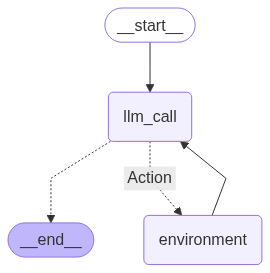

In [28]:
from typing_extensions import Literal

from langchain_core.messages.utils import (
    trim_messages,
    count_tokens_approximately
)

from IPython.display import Image, display
from langchain_core.messages import SystemMessage, ToolMessage
from langgraph.graph import END, START, MessagesState, StateGraph

# Define extended state with summary field
class State(MessagesState):
    """Extended state that includes a summary field for context compression."""
    summary: str

# Define the RAG agent system prompt
rag_prompt = """You are a helpful assistant tasked with retrieving information from a series of technical blog posts by Lilian Weng. 
Clarify the scope of research with the user before using your retrieval tool to gather context. Reflect on any context you fetch, and
proceed until you have sufficient context to answer the user's research request."""

# Define the summarization prompt
summarization_prompt = """Summarize the full chat history and all tool feedback to 
give an overview of what the user asked about and what the agent did."""

def llm_call(state: MessagesState) -> dict:
    """Execute LLM call with system prompt and message history.
    
    This function demonstrates context pruning by trimming messages to fit within
    token limits while maintaining conversation coherence.
    
    Args:
        state: Current conversation state
        
    Returns:
        Dictionary with new messages
    """
    # First, trim the messages to manage context size
    # Using allow_partial to ensure we keep at least some content
    trimmed_messages = trim_messages(
        state["messages"],
        strategy="last",
        token_counter=count_tokens_approximately,
        max_tokens=4000,  # More reasonable limit
        start_on="human",  # Ensure we start with human message
        include_system=False,  # Don't include system messages in trimming
        allow_partial=True,  # Allow partial messages if needed
    )
    
    # Fallback: if trimming results in empty list, keep at least the last message
    if not trimmed_messages and state["messages"]:
        trimmed_messages = state["messages"][-1:]
        print("⚠️  Trimming resulted in empty list, keeping last message as fallback")
    
    # Add system prompt to the trimmed messages
    messages = [SystemMessage(content=rag_prompt)] + trimmed_messages
    
    print(f"Original messages: {len(state['messages'])}")
    print(f"Trimmed messages: {len(trimmed_messages)}")
    print(f"Final messages (with system): {len(messages)}")
    
    # Ensure we have at least one non-system message
    if len(messages) <= 1:
        print("⚠️  Only system message found, this will cause API error")
        return {"messages": []}  # Return empty to handle gracefully
    
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

def tool_node(state: MessagesState) -> dict:
    """Execute tool calls and return results.
    
    Args:
        state: Current conversation state with tool calls
        
    Returns:
        Dictionary with tool results
    """
    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}


def should_continue(state: MessagesState) -> Literal["Action", "__end__"]:
    """Determine next step based on whether LLM made tool calls.
    
    Args:
        state: Current conversation state
        
    Returns:
        Next node to execute
    """
    messages = state["messages"]
    if not messages:
        return END
        
    last_message = messages[-1]
    
    # If LLM made tool calls, execute them
    if last_message.tool_calls:
        return "Action"
    # Otherwise, proceed to summarization
    return END

# Build the RAG agent workflow
agent_builder = StateGraph(State)

# Add nodes to the workflow
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("environment", tool_node)

# Define the workflow edges
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        "Action": "environment",
        END: END,
    },
)
agent_builder.add_edge("environment", "llm_call")

# Compile the agent
agent = agent_builder.compile()

# Display the agent workflow
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [29]:
from utils import format_messages
query = "Why does RL improve LLM reasoning according to the blogs?"
result = agent.invoke({"messages": [{"role": "user", "content": query}]})
format_messages(result['messages'])

Original messages: 1
Trimmed messages: 1
Final messages (with system): 2
⚠️  Trimming resulted in empty list, keeping last message as fallback
Original messages: 3
Trimmed messages: 1
Final messages (with system): 2


BadRequestError: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages.0.content.0: unexpected `tool_use_id` found in `tool_result` blocks: toolu_01AEsnt9Jp2LYnLgPJJtZ6Qv. Each `tool_result` block must have a corresponding `tool_use` block in the previous message.'}}